In [1]:
import numpy as np
import healpy as hp
from rubin_scheduler.scheduler.utils import EuclidOverlapFootprint
import matplotlib.pylab as plt
%matplotlib inline
from rubin_scheduler.utils import hpid2_ra_dec

In [2]:
fp = EuclidOverlapFootprint()
maps,labels = fp.return_maps(magellenic_clouds_ratios={},  virgo_ratios={}, scp_ratios={} , nes_ratios={}, bulge_ratios={},
                     dusty_plane_ratios={}, low_dust_ratios={})

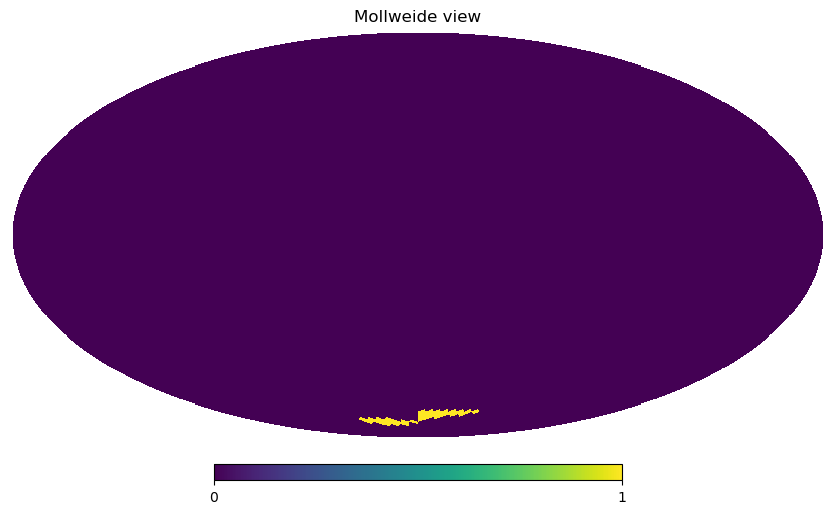

In [3]:
hp.mollview(maps['r'])

In [15]:
def _hp_in_polygon(nside, ra, dec):
    """Find healpix that are inside a given region defined by ra,dec points

    Assuming RA,dec points are in the proper order.
    """
    
    hpids = np.arange(hp.nside2npix(nside))
    result = np.zeros(hpids.size)
    hpid_ra, hpid_dec = hpid2_ra_dec(nside, hpids)

    # XXX check if we cross over RA=0, shift things around if needed
    ra_offset = np.min(ra)
    ra = ra - ra_offset
    hpid_ra = (hpid_ra - ra_offset) % 360
    
    # crop down to the potential hpids we need to consider
    hpid_to_test = np.where((hpid_dec >= dec.min()) & (hpid_dec <= dec.max()) & (hpid_ra >=ra.min()) & (hpid_ra <= ra.max()))[0]
    
    starting_ra = np.concatenate([[ra[-1]],ra])
    ending_ra = np.concatenate([ra, [ra[0]]])
    starting_dec = np.concatenate([[dec[-1]],dec])
    ending_dec = np.concatenate([dec, [dec[0]]])

    for hpid in hpid_to_test:
        crossers = np.where( ((starting_dec <= hpid_dec[hpid]) & (ending_dec >= hpid_dec[hpid])) | 
                               ((starting_dec >= hpid_dec[hpid]) & (ending_dec <= hpid_dec[hpid])) )[0]
        # for each of those, let's interpolate the ra to the right dec. If ra is greater, then it's a cross
        slopes = (ending_dec[crossers] - starting_dec[crossers])/(ending_ra[crossers] - starting_ra[crossers])
        ra_interp = (hpid_dec[hpid] - (starting_dec[crossers] - slopes*starting_ra[crossers]))/slopes
        crossers = np.where(ra_interp >= hpid_ra[hpid])[0] 
        # If we have an odd number of crossings, then we are inside
        if crossers.size % 2 == 1:
            result[hpid] = 1

    return result

In [16]:
names = ["RA", "dec"]
types = [float, float]
euclid_contours = np.genfromtxt("/Users/yoachim/rubin_sim_data/scheduler/EWS.SGC.Mainland.ROI.2022.RADEC.txt", dtype=list(zip(names, types)))

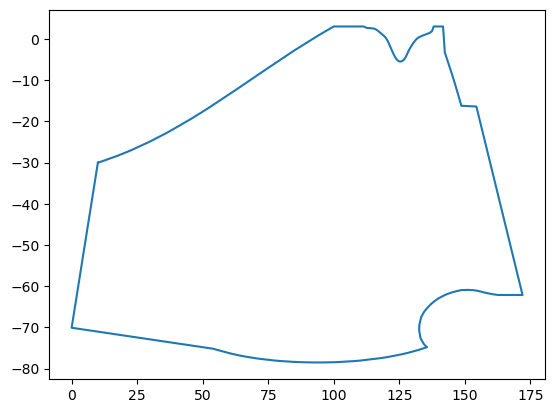

In [17]:
plt.plot(euclid_contours["RA"]-euclid_contours["RA"].min(), euclid_contours["dec"])

In [18]:
ack = _hp_in_polygon(128, euclid_contours["RA"], euclid_contours["dec"])

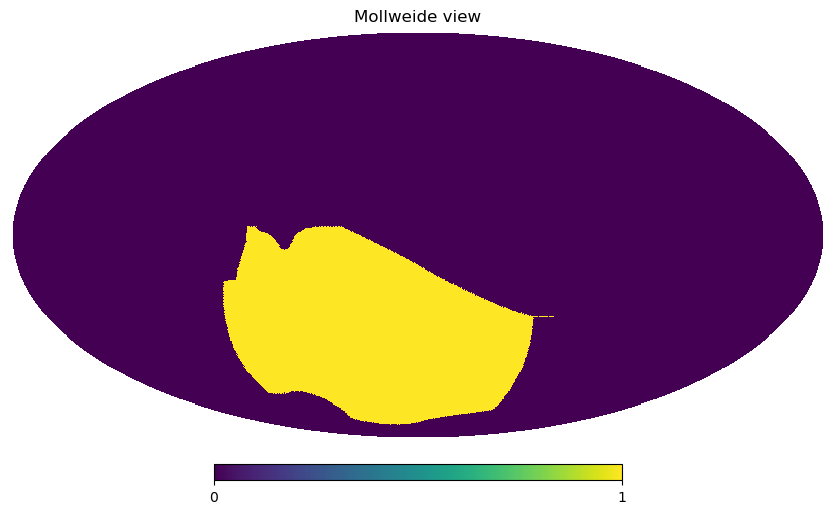

In [19]:
hp.mollview(ack)